In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sb
import requests
import os
import csv
import tarfile
from zlib import crc32
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [1]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
base_color = sb.color_palette()[0]

# Get the Data

In [5]:
HOUSING_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join('datasets', 'housing')

In [6]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    response = requests.get(housing_url)
    housing_dir = os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    with open(tgz_path, 'wb') as f:
        f.write(response.content)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [8]:
fetch_housing_data()

In [9]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [10]:
housing = load_housing_data()

In [11]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


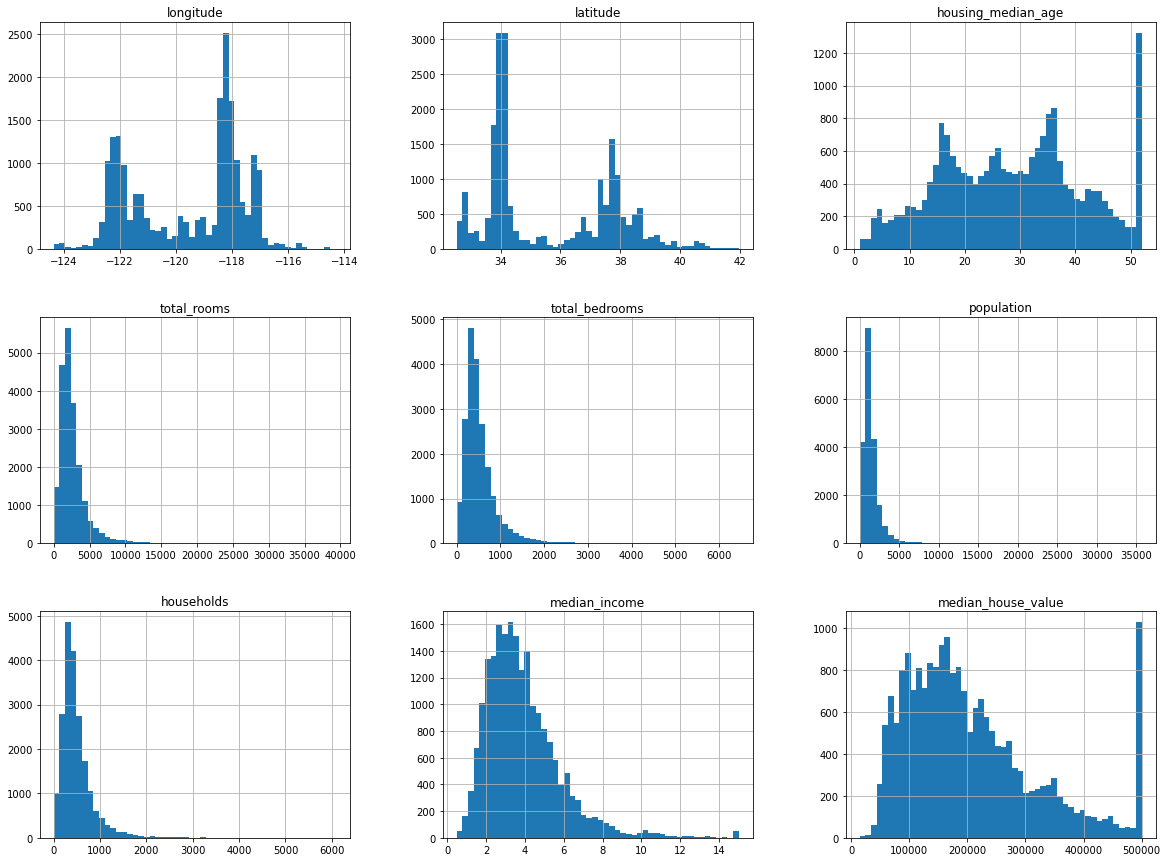

In [11]:
housing.hist(figsize = (20,15), bins = 50);

In [12]:
#This is because of the magic command "%matplotlib inline"
plt.get_backend()

'module://ipykernel.pylab.backend_inline'

- Matplotlib relies on a user-specified graphical backend to draw on your screen.

In [13]:
housing.loc[housing['housing_median_age'] > 50]['housing_median_age'].value_counts()

52.0    1273
51.0      48
Name: housing_median_age, dtype: int64

In [14]:
housing.loc[housing['median_house_value'] > 500000]['median_house_value'].value_counts()

500001.0    965
Name: median_house_value, dtype: int64

### Create a Test Set

- If you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of machine learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected.

In [15]:
#This ensures that the same test set will be generated in each run
np.random.seed(42)

In [16]:
#This same function can be implemented by sklearn's train_test_split() function
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [17]:
train_set, test_set = split_train_test(housing, 0.2)

In [18]:
print(f'training set shape: {train_set.shape}, test set shape: {test_set.shape}')

training set shape: (16512, 10), test set shape: (4128, 10)


In [19]:
#Using sklearn's train_test_split() function
train_set1, test_set1 = train_test_split(housing, test_size = 0.2, random_state = 42)

In [20]:
print(f'training set shape: {train_set1.shape}, test set shape: {test_set1.shape}')

training set shape: (16512, 10), test set shape: (4128, 10)


In [21]:
(train_set == train_set1).all()

longitude             True
latitude              True
housing_median_age    True
total_rooms           True
total_bedrooms        True
population            True
households            True
median_income         True
median_house_value    True
ocean_proximity       True
dtype: bool

In [22]:
(test_set == test_set1).all()

longitude              True
latitude               True
housing_median_age     True
total_rooms            True
total_bedrooms        False
population             True
households             True
median_income          True
median_house_value     True
ocean_proximity        True
dtype: bool

- The above method will break the next time you fetch an updated dataset.
- To have a stable dataset, one solution is to use each instance's identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier).
- You could compute a hash of each instance's identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value.
- This ensures that the test set will remain consistent across multiple runs, even if you refresh the test set.

In [23]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [24]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.map(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [25]:
housing_with_id = housing.reset_index()

In [26]:
train_set, test_test = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [27]:
train_set.shape

(16512, 11)

In [28]:
test_set.shape

(4128, 10)

- The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

##### Stratified Sampling

1. The population is divided into homogeneous subgroups called strata.
2. The right number of instances are sampled from each stratum.
3. This guarantee that the test set is representative of the overall population.

- It is important to have a sufficient number of instances in your datatest for each stratum, or else the estimate of a stratum's importance may be biased.
- This means that you shouldn't have too many strata, and each stratum should be large enough.

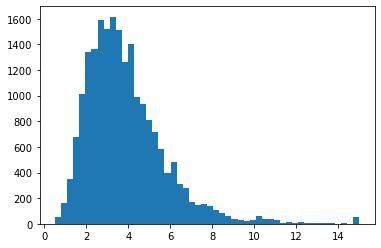

In [29]:
plt.hist(housing['median_income'], bins = 50);

In [30]:
def log_transform(x, inverse = False):
    if not inverse:
        return np.log2(x)
    else:
        return 2 ** x

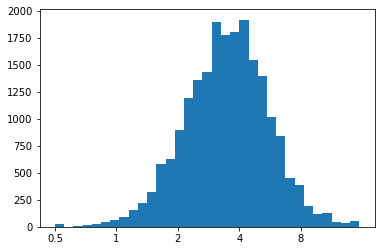

In [31]:
minimum = log_transform(housing['median_income']).describe()['min']
maximum = log_transform(housing['median_income']).describe()['max']
bin_edges = np.arange(minimum, maximum + 0.15, 0.15)
plt.hist(log_transform(housing['median_income']), bins = bin_edges)
tick_loc = [-1, 0, 1,  2,  3]
plt.xticks(tick_loc, [log_transform(i, inverse = True) for i in tick_loc]);

In [32]:
housing['income_cat'] = pd.cut(housing['median_income'], bins = [0, 1.5, 3, 4.5, 6, np.inf], labels = [1,2,3,4,5])

In [33]:
level_order = [1,2,3,4,5]
ordered_cat = pd.api.types.CategoricalDtype(categories = level_order, ordered = True)
housing['income_cat'] = housing['income_cat'].astype(ordered_cat)

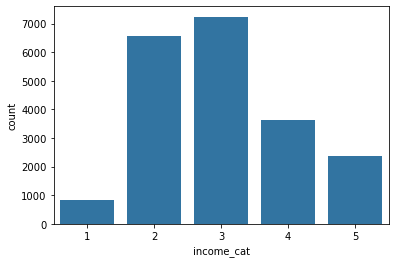

In [34]:
sb.countplot(data = housing, x = 'income_cat', color = base_color);

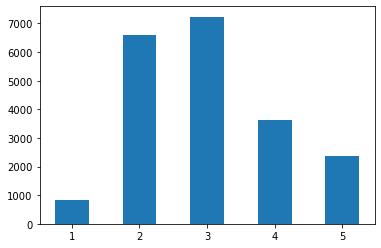

In [35]:
plt.hist(data = housing, x = 'income_cat', bins = [1,2,3,4,5,6], rwidth = 0.5)
ticks = [1,2,3,4,5]
plt.xticks([i + 0.5 for i in ticks], ticks);

In [36]:
sss= StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [37]:
#income category proportions in the overall dataset
(housing['income_cat'].value_counts() / len(housing)).sort_index()

1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: income_cat, dtype: float64

In [38]:
#income category proportions in the training set generated by stratified sampling
(strat_train_set['income_cat'].value_counts() / len(strat_train_set)).sort_index()

1    0.039850
2    0.318859
3    0.350594
4    0.176296
5    0.114402
Name: income_cat, dtype: float64

In [39]:
#income category proportions in the test set generated by stratified sampling
(strat_test_set['income_cat'].value_counts() / len(strat_test_set)).sort_index()

1    0.039729
2    0.318798
3    0.350533
4    0.176357
5    0.114583
Name: income_cat, dtype: float64

In [40]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#income category proportions in the test set generated by random sampling
(test_set['income_cat'].value_counts() / len(test_set)).sort_index()

1    0.040213
2    0.324370
3    0.358527
4    0.167393
5    0.109496
Name: income_cat, dtype: float64

In [41]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [42]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [43]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis =1, inplace = True)

# Discover and Visualize the Data to Gain Insights

- Make sure that you're only exploring the training set.
- If your training set is very large, you may want to make an exploration set to make manipulations easy and fast.

In [44]:
housing = strat_train_set.copy()

In [45]:
housing.shape

(16512, 10)

In [46]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


### Visualizing Geographical Data

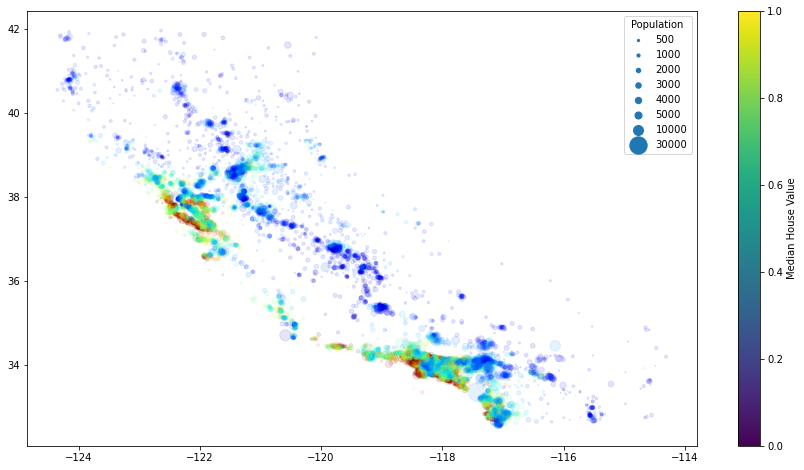

In [47]:
plt.figure(figsize = (15,8))
plt.scatter(data = housing, x = 'longitude', y = 'latitude', alpha = 0.1,
           c = 'median_house_value', s = housing['population'] / 100, cmap = 'jet')
sizes = [500, 1000, 2000, 3000, 4000, 5000, 10000, 30000]
legend_obj = []
for s in sizes:
    legend_obj.append(plt.scatter([], [], s = s / 100, color = base_color))
plt.colorbar(label = 'Median House Value')
plt.legend(legend_obj, sizes, title = 'Population');

In [ ]:
image_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png"
images_path = 'images'
images_dir = os.mkdir(images_path)
response = requests.get(image_url)
file_name = 'california.png'
cal_path = os.path.join(images_path, file_name)
with open(cal_path, 'wb') as f:
        f.write(response.content)

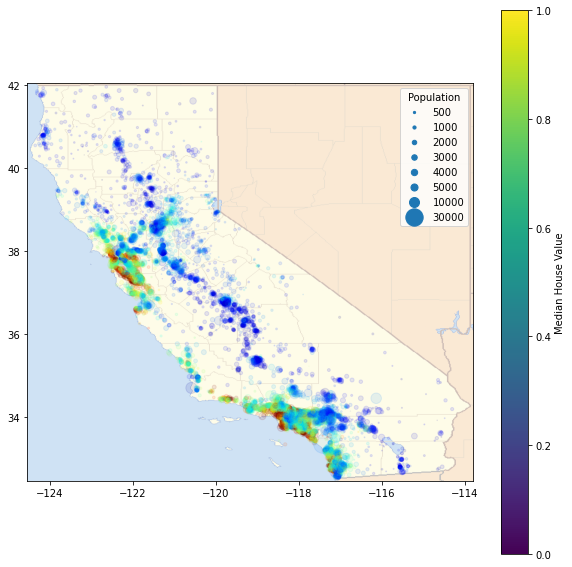

In [48]:
plt.figure(figsize = (10,10))
cal_img = mpimg.imread('images/california.png')
plt.imshow(cal_img, extent = [-124.55, -113.80, 32.45, 42.05], alpha = 0.5)
plt.scatter(data = housing, x = 'longitude', y = 'latitude', alpha = 0.1,
           c = 'median_house_value', s = housing['population'] / 100, cmap = 'jet')
sizes = [500, 1000, 2000, 3000, 4000, 5000, 10000, 30000]
legend_obj = []
for s in sizes:
    legend_obj.append(plt.scatter([], [], s = s / 100, color = base_color))
plt.colorbar(label = 'Median House Value')
plt.legend(legend_obj, sizes, title = 'Population');

In [49]:
housing.groupby('ocean_proximity')['median_house_value'].mean().sort_values(ascending = False)

ocean_proximity
ISLAND        351100.000000
NEAR BAY      258740.476448
NEAR OCEAN    248359.495763
<1H OCEAN     240820.716465
INLAND        125310.872316
Name: median_house_value, dtype: float64

In [50]:
sizes = [0, 500, 1000, 2000, 3000, 4000, 5000, 10000, 30000, 40000]
population_cat = pd.cut(housing['population'], bins = sizes, labels = [1,2,3,4,5,6,7,8, 9])
housing.groupby(population_cat)['median_house_value'].mean().sort_values().astype(int)

population
9    134400
7    197760
6    198677
5    201451
4    202437
3    203172
1    204529
2    216412
8    217486
Name: median_house_value, dtype: int32

- The housing prices are very much related to the location and to the population density.

### Looking for Correlations

- The `corr()` method measures the **standard correlation coefficient (pearson's r)**.

In [51]:
corr_matrix = housing.corr()

In [52]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

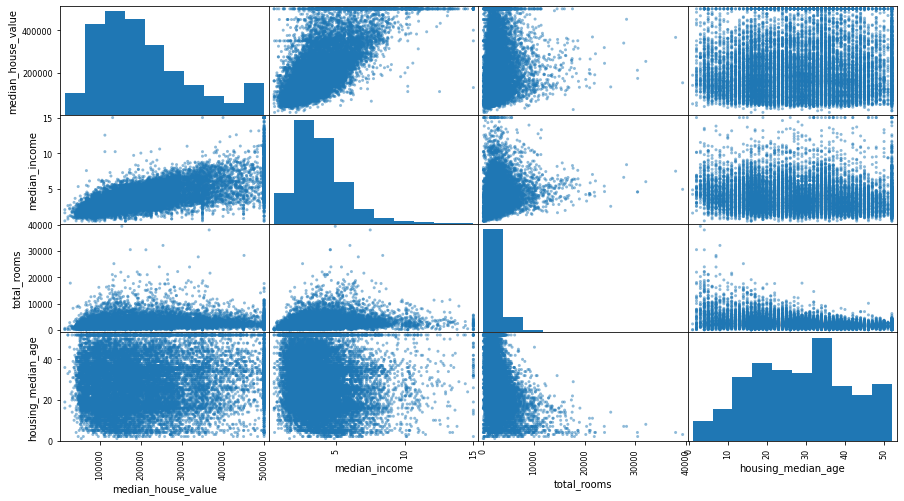

In [53]:
#scatter matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing[attributes], figsize = (15,8));

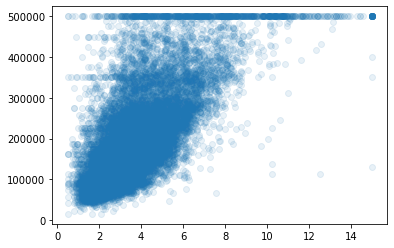

In [54]:
plt.scatter(data = housing, x = 'median_income', y = 'median_house_value', alpha = 0.1)

### Experimenting with Attribute Combinations

- rooms per household
- bedrooms per room
- population per household

In [55]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [56]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [57]:
corr_matrix = housing.corr()

In [58]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

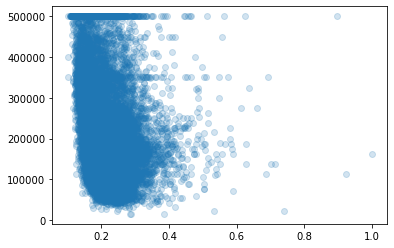

In [59]:
plt.scatter(data = housing, x = 'bedrooms_per_room', y = 'median_house_value', alpha = 0.2)

(0.0, 7.5)

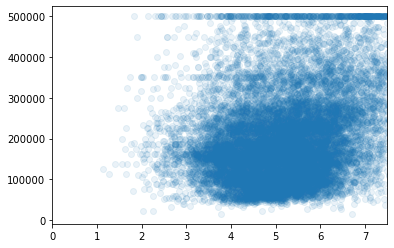

In [60]:
plt.scatter(data = housing, x = 'rooms_per_household', y = 'median_house_value', alpha = 0.09)
plt.xlim(0,7.5)

# Prepare the Data for Machine Learning Algorithms

In [61]:
#Separate the predictors and labels
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

- Work on copies of the data to keep the original data intact.
- Write functions for all data transformations you apply, for five reasons:
    1. So you can easily prepare the data the next time you get a fresh dataset.
    2. So you can apply these transformations in future projects.
    3. To clean and prepare the test set.
    4. To clean and prepare new data instances once your solution is live.
    5. To make it easy to treat your preparation choices as hyperparameters.

In [62]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [63]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

### Data Cleaning

In [64]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [65]:
housing[(housing.isnull()).any(axis = 1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,NaN,1886.0,769.0,2.6036,<1H OCEAN
4691,-118.37,34.07,50.0,2519.0,NaN,1117.0,516.0,4.3667,<1H OCEAN
6052,-117.76,34.04,34.0,1914.0,NaN,1564.0,328.0,2.8347,INLAND
17198,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,NEAR OCEAN


##### Handling Missing Values

- The `total_bedrooms` attribute has some missing values.

- There are many options for dealing with missing values:
1. Get rid of instances with missing values.

    `housing.dropna(subset = ['total_bedrooms'], inplace = True)`
    
    
2. Get rid of the attribute altogether.

    `housing.drop('total_bedrooms', axis = 1, inplace = True)`
    
    
3. Fill in the missing values (zero, mean, median, etc.).

    `housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace = True)`
    
    
4. Train a model with the attribute and another one without it.

- If we choose to fill in the missing values with the median of the attribute, we should compute the median value on the training set, and save the median. The median value will be used to fill in the missing value in the training set, the test set, and the new data when your system goes live.

In [66]:
#An imputer object (an estimator) that handles missing values
imputer = SimpleImputer(strategy = 'median')

In [67]:
#Compute the median only on numerical attributes
housing_num = housing.drop('ocean_proximity', axis = 1)

In [68]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [69]:
#You can access an estimator's hyperparameters directly via public instance variables
imputer.strategy

'median'

In [70]:
#You can access an estimator's learned parameters via public instance variables with an underscore suffix
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

- The imputer has simply computed the median of each attribute

In [71]:
housing.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [72]:
#Returns a plain Numpy array
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [73]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [74]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [75]:
housing_tr[housing_tr.isna().any(axis = 1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


### Handling Text and Categorial Attributes

In [76]:
housing_cat = housing[['ocean_proximity']]

In [77]:
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [78]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

- `ocean_proximity` is a categorical attributes with five possible categories.

In [79]:
ordinal_encoder = OrdinalEncoder()

In [80]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [81]:
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [82]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- The `categories_` instance variable returns a list containing a 1D array of categories for each categorical attribute.
- With ordianl encoding, there is clear ordering of the categories; that is two nearby categories are more similar than two distant ones.

In [83]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [84]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- The output is a **SciPy sparse matrix**, which only stores the location of the non zero elements, instead of a **dense NumPy array**.

In [85]:
#Convert it to a dense NumPy array
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [86]:
#Another way
housing_cat_1hot.todense()

matrix([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [87]:
pd.get_dummies(housing_cat).values

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [88]:
#Another way
cat_encoder = OneHotEncoder(sparse = False)
cat_encoder.fit_transform(housing_cat)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformers

- Sometimes you will need to write your own custom transformers for tasks such as custom clean up operations, or combining specific attributes.
- You will want your transformer to work seemlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods:
        a. fit() ---> return self (There are no parameters to learn)
        b. transform()
        c. fit_transform() ---> you can get this method for free by simply adding `TransformerMixin` as a base class.
- If you also add `BaseEstimator` as a base class (and avoid `*args` and `**kwargs` in your constructor), you will also get two extra methods (`get_params()` and `set_params()`) that will be useful for automatic hyperparameter tuning.
- Duck typing is a concept related to dynamic typing, where the type or the class of an object is less important than the methods it defines. When you use duck typing, you do not check types at all. Instead, you check for the presence of a given method or attribute.

In [89]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin

In [91]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

In [92]:
#A cleaner and more dynamic way to get the column indices
col_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]

In [93]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [94]:
att_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = att_adder.transform(housing.values)

In [95]:
housing_extra_attribs.shape

(16512, 11)

- The above transformer has only one hyperparameter, `add_bedrooms_per_room`.
- You can add a hyperparameter to gate any data preparation steps that you are not 100% sure about.
- You can treat some of the data preparation steps as hyperparameters.

In [96]:
pd.DataFrame(housing_extra_attribs, columns = list(housing) + ['rooms_per_household', 'population_per_household'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
2,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847
...,...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.2,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND,6.052381,2.728571
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND,4.635659,4.077519
16509,-116.4,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND,6.346405,2.742484
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN,5.505618,3.808989


### Feature Scaling

- Most machine learning algorithms do not perform well when the input numerical attributes have very different scales.
- Scaling the target values (y) is generally not required.

- There are two common ways of feature scaling:
    1. Normalization (min-max scaling)
        - Features are scaled so that they end up ranging from 0 to 1.
    2. Standardization
        - Results in a normal distribution.
        - Does not bound values to a specific range.
        - It is less affected by outliers.

- As with all transformations, it is important to fit the scalers to the training data only, not to the full dataset. Only then can you use them to transform the training set, test set, and the new data.

### Transformation Pipelines

- The pipeline takes a list of **name/estimator** pairs defining a sequence of steps.
- All but the last estimator must be transformers (they must have a `fit_transform()` method).
- When you call the pipeline's `fit()` method, it calls `fit_transform()` sequentially on all the transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.
- The pipeline exposes the same methods as the final estimator.

In [97]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [98]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [99]:
#Another way
#num_pipleline.fit(housing_num)
#housing_num_tr = num_pipeline.transform(housing_num)

In [100]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [101]:
num_pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'attribs_adder': CombinedAttributesAdder(),
 'std_scaler': StandardScaler()}

##### Column Transformer

- A single transformer that is able to handle all columns, numerical and categorical, applying the appropriate transformations to each column.
- It can work with Pandas DataFrames.

In [102]:
#Transformations pipeline
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [103]:
housing_prepared = full_pipeline.fit_transform(housing)

In [104]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Select and Train a Model

### Training and Evaluating on the Training Set

- If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (this may penalize complex models such as large neural nets or Random Forests).

##### Linear Regression

In [105]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [106]:
#Testing the model
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
pred = lin_reg.predict(some_data_prepared)

In [107]:
print('Predictions: ', [float('{:0.2f}'.format(v)) for v in pred])
print('Labels: ', list(some_labels))

Predictions:  [210644.6, 317768.81, 210956.43, 59218.99, 189747.56]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


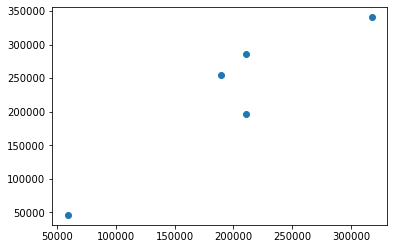

In [108]:
plt.scatter(pred, some_labels);

In [109]:
#Measuring the regression model's RMSE on the whole training set
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [110]:
print(lin_mse)

4709829587.97112


In [111]:
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [112]:
#Another way
mean_squared_error(housing_labels, housing_predictions, squared = False)

68628.19819848922

In [113]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

- The model is **underfitting** the training data.
- Solutions to underfitting:

    1. Select a more powerful model.
    2. Feed the training algorithm with better features.
    3. Reduce the constraints on the model.

##### Decision Tree Regressor

- It is a powerful model, capable of finding complex non-linear relationships in the data.

In [114]:
tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [115]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)

In [116]:
tree_rmse

0.0

In [117]:
tree_mae = mean_absolute_error(housing_labels, housing_predictions)
tree_mae

0.0

- The Decision Tree model has badly overfit the data.
- We need to create a validation (development) set for model validation.

### Better Evaluation Using Cross-Validation

- There are two options:
    
    1. Split the training set using `train_test_spit()` into a smaller training set and a validation set, then train the models against the smaller training set and evaluate them against the validation set.
    2. Use sklearn's **K-fold cross validation** feature. 

The scoring parameter: defining model evaluation rules: https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

In [118]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', 
                        cv = 10)

- Number of folds is specified by `cv` parameter.
- `cross_val_score`'s `scoring` parameter expects a utility function "scoring function" (greater is better) rather than a cost function (lower is better).
- Returns scores: ndarray of float of shape=(len(list(cv)),) **containing the evaluation scores**.
- With `cross_val_score`, not only you can estimate the performance of the model, but also measure how precise this estimate is using standard deviation.
- Cross validation comes at the cost of training the model several times, so it is not always possible.

- functions ending with `_score` return a value to maximize, **the higher the better**.
- functions ending with `_error` or `_loss` return a value to minimize, **the lower the better**. When converting into a **scorer object** using `make_scorer`, set the `greater_is_better` parameter to **False** (True by default).

In [119]:
tree_scores

array([-4.92724492e+09, -4.46961291e+09, -5.24647900e+09, -5.00679914e+09,
       -5.05746872e+09, -5.71311365e+09, -4.93686969e+09, -4.93838343e+09,
       -5.68016653e+09, -5.07394900e+09])

In [120]:
tree_rmse_scores = np.sqrt(-tree_scores)

In [121]:
tree_rmse_scores

array([70194.33680785, 66855.16363941, 72432.58244769, 70758.73896782,
       71115.88230639, 75585.14172901, 70262.86139133, 70273.6325285 ,
       75366.87952553, 71231.65726027])

In [122]:
#Another implementation
ts = cross_val_score(DecisionTreeRegressor(random_state = 42), housing_prepared, housing_labels, 
                    scoring = make_scorer(mean_squared_error), cv = 10)
np.sqrt(ts)

array([70194.33680785, 66855.16363941, 72432.58244769, 70758.73896782,
       71115.88230639, 75585.14172901, 70262.86139133, 70273.6325285 ,
       75366.87952553, 71231.65726027])

In [123]:
#Another implementation
ts = cross_val_score(DecisionTreeRegressor(random_state = 42), housing_prepared, housing_labels, 
                    scoring = make_scorer(mean_squared_error, greater_is_better = False), cv = 10)
np.sqrt(-ts)

array([70194.33680785, 66855.16363941, 72432.58244769, 70758.73896782,
       71115.88230639, 75585.14172901, 70262.86139133, 70273.6325285 ,
       75366.87952553, 71231.65726027])

In [124]:
def display_scores(scores):
    scores = [float('{:0.2f}'.format(v)) for v in scores]
    print('Scores: ', scores)
    print('Mean: ', np.mean(scores))
    print('Standard Deviation: ', np.std(scores))

In [125]:
display_scores(tree_rmse_scores)

Scores:  [70194.34, 66855.16, 72432.58, 70758.74, 71115.88, 75585.14, 70262.86, 70273.63, 75366.88, 71231.66]
Mean:  71407.687
Standard Deviation:  2439.4348658246645


- The Decision Tree actually performs worse than the Linear Regression model.

In [126]:
#cross_val of linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', 
                            cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [127]:
display_scores(lin_rmse_scores)

Scores:  [66782.74, 66960.12, 70347.95, 74739.57, 68031.13, 71193.84, 64969.63, 68281.61, 71552.92, 67665.1]
Mean:  69052.461
Standard Deviation:  2731.674062403676


- The Decision Tree model is overfitting the data so badly that it performs worse than the Linear Regression model.

##### Random Forest Regressor

- Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.
- Building a model on top of many other models is called **Ensemble Learning**.

In [128]:
forest_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [129]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
forest_rmse

18603.515021376355

In [130]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', 
                            cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores

array([49519.80364233, 47461.9115823 , 50029.02762854, 52325.28068953,
       49308.39426421, 53446.37892622, 48634.8036574 , 47585.73832311,
       53490.10699751, 50021.5852922 ])

In [131]:
display_scores(forest_rmse_scores)

Scores:  [49519.8, 47461.91, 50029.03, 52325.28, 49308.39, 53446.38, 48634.8, 47585.74, 53490.11, 50021.59]
Mean:  50182.303
Standard Deviation:  2097.0821322401744


- The score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training data.

- You should save every model you experiment with so that you can come back easily to any model you want.

# Fine-Tune Your Model

### Grid Search

- What hyperparameters you want to experiment with, and what values to try out.
- GridSearchCV will use cross validation to evaluate **all the possible combinations** of hyperparameters.
- Grid Search is a good approach when you are exploring relatively few combinations of hyperparameters.

In [134]:
param_grid = [
    #Try 12 (3x4) combinations of hyperparameters
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    #Then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(estimator = forest_reg, param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [139]:
#The best estimator
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [140]:
#The best combination of parameters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [141]:
#The evaluation scores
cvres = grid_search.cv_results_

In [142]:
cvres_df = pd.DataFrame(cvres)
cvres_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.044458,0.002749,0.003192,0.000399,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.144631,0.003833,0.006975,0.000015,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.425530,0.005078,0.019547,0.000490,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.069891,0.000641,0.002394,0.000491,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.227409,0.000956,0.006774,0.000394,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07


In [143]:
cvres_df[cvres_df['rank_test_score'] == 1]['params']

11    {'max_features': 8, 'n_estimators': 30}
Name: params, dtype: object

In [145]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

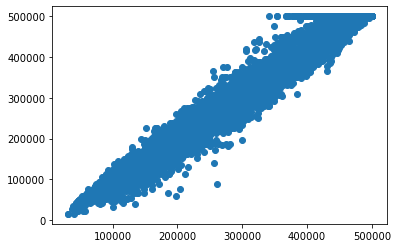

In [146]:
plt.scatter(grid_search.predict(housing_prepared), housing_labels);

In [147]:
#cross validation 
grid_search_scores = cross_val_score(grid_search, housing_prepared, housing_labels, 
                                    scoring = 'neg_mean_squared_error', cv = 10)

In [148]:
grid_search_rmse_scores = np.sqrt(-grid_search_scores)
grid_search_rmse_scores

array([48645.61828036, 47015.07160785, 48815.41490315, 50878.90046882,
       49678.58174403, 52845.44320575, 48277.73810628, 47238.69199385,
       51977.6157641 , 49203.58794769])

In [149]:
display_scores(grid_search_rmse_scores)

Scores:  [48645.62, 47015.07, 48815.41, 50878.9, 49678.58, 52845.44, 48277.74, 47238.69, 51977.62, 49203.59]
Mean:  49457.666000000005
Standard Deviation:  1825.2317956369275


In [150]:
param_grid = [
    #Try 12 (3x4) combinations of hyperparameters
    {'n_estimators':[30, 40, 50], 'max_features':[8, 10, 12, 14]},
    #Then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap':[False], 'n_estimators':[30, 40], 'max_features':[8, 10, 12]}
]

forest_reg = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(estimator = forest_reg, param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [8, 10, 12, 14],
                          'n_estimators': [30, 40, 50]},
                         {'bootstrap': [False], 'max_features': [8, 10, 12],
                          'n_estimators': [30, 40]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [152]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=8, n_estimators=40,
                      random_state=42)

In [154]:
cvres = grid_search.cv_results_

In [155]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49682.273345071546 {'max_features': 8, 'n_estimators': 30}
49504.61171066941 {'max_features': 8, 'n_estimators': 40}
49299.900206837825 {'max_features': 8, 'n_estimators': 50}
50248.50830956178 {'max_features': 10, 'n_estimators': 30}
49936.64370838097 {'max_features': 10, 'n_estimators': 40}
49738.522046612845 {'max_features': 10, 'n_estimators': 50}
50175.90329245697 {'max_features': 12, 'n_estimators': 30}
49993.98047305722 {'max_features': 12, 'n_estimators': 40}
49919.72975498698 {'max_features': 12, 'n_estimators': 50}
50684.16352332851 {'max_features': 14, 'n_estimators': 30}
50389.13469990444 {'max_features': 14, 'n_estimators': 40}
50349.39777323097 {'max_features': 14, 'n_estimators': 50}
48884.43162255064 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
48780.22373827826 {'bootstrap': False, 'max_features': 8, 'n_estimators': 40}
49775.62788136235 {'bootstrap': False, 'max_features': 10, 'n_estimators': 30}
49522.89361249639 {'bootstrap': False, 'max_features': 10

In [157]:
min(np.sqrt(-cvres['mean_test_score']))

48780.22373827826

### Randomized Search

- Randomized Search is prefered over Grid Search if the hyperparameter search space is large.
- With Randomized Search, instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at each iteration.

In [179]:
param_distribs = {
    'n_estimators': [i for i in range(1,201)],
    'max_features':[i for i in range(1,9)]
}

forest_reg = RandomForestRegressor(random_state = 42)
rnd_search = RandomizedSearchCV(estimator = forest_reg,
                                param_distributions = param_distribs,
                                n_iter = 10, #Setting the number of iterations gives you more control over the computing budget
                                cv = 5,
                                scoring = 'neg_mean_squared_error',
                                random_state = 42)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': [1, 2, 3, 4, 5, 6, 7,
                                                         8],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   random_state=42, scoring='neg_mean_squared_error')

In [181]:
rnd_search.best_params_

{'n_estimators': 60, 'max_features': 8}

In [182]:
cvres = rnd_search.cv_results_
cvres_df= pd.DataFrame(cvres)

In [183]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49318.43934045708 {'n_estimators': 127, 'max_features': 6}
49201.178293036166 {'n_estimators': 60, 'max_features': 8}
49852.07993761475 {'n_estimators': 61, 'max_features': 5}
49327.63464282182 {'n_estimators': 95, 'max_features': 7}
49329.13210311672 {'n_estimators': 131, 'max_features': 6}
49412.68041971756 {'n_estimators': 96, 'max_features': 6}
49713.2105149931 {'n_estimators': 45, 'max_features': 6}
54591.52978479093 {'n_estimators': 122, 'max_features': 1}
50872.62017337918 {'n_estimators': 67, 'max_features': 3}
49885.35466090573 {'n_estimators': 39, 'max_features': 7}


In [184]:
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low = 1, high = 200),
    'max_features': randint(low = 1, high = 8)
}

forest_reg = RandomForestRegressor(random_state = 42)
rnd_search = RandomizedSearchCV(estimator = forest_reg,
                                param_distributions = param_distribs,
                                n_iter = 10, #Setting the number of iterations gives you more control over the computing budget
                                cv = 5,
                                scoring = 'neg_mean_squared_error',
                                random_state = 42)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C20DF19970>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C20DF0CB50>},
                   random_state=42, scoring='neg_mean_squared_error')

In [185]:
cvres = rnd_search.cv_results_
cvres_df= pd.DataFrame(cvres)

In [186]:
cvres_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.555275,0.129380,0.115500,5.673481e-03,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.274768e+09,-2.475113e+09,-2.558241e+09,-2.261587e+09,-2.509251e+09,-2.415792e+09,1.234603e+08,1
1,0.410779,0.002082,0.010097,4.691265e-04,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.493183e+09,-2.727145e+09,-2.747621e+09,-2.505491e+09,-2.731163e+09,-2.640921e+09,1.158711e+08,9
2,1.339335,0.009413,0.044880,1.168008e-07,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.432244e+09,-2.669938e+09,-2.663783e+09,-2.416819e+09,-2.718463e+09,-2.580249e+09,1.286391e+08,7
3,0.577660,0.003851,0.013364,4.885388e-04,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.425443e+09,-2.685426e+09,-2.684721e+09,-2.445756e+09,-2.679708e+09,-2.584211e+09,1.215266e+08,8
4,4.472450,0.023045,0.076396,7.977011e-04,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.295829e+09,-2.490105e+09,-2.567315e+09,-2.275918e+09,-2.513890e+09,-2.428612e+09,1.193643e+08,2


In [187]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

In [188]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


### Ensemble Learning

- Try to combine the models that perform best.
- The group (or ensemble) will often perform better than the best individual model, especially if the individual models make very different types of errors.

### Analyze the Best Models and their Errors

In [189]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=8, n_estimators=40,
                      random_state=42)

In [191]:
#The relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.60926513e-02, 6.82548679e-02, 4.18260932e-02, 1.49733309e-02,
       1.37517130e-02, 1.41412636e-02, 1.37798662e-02, 3.74444508e-01,
       5.43570221e-02, 1.09280756e-01, 4.50810310e-02, 6.20539751e-03,
       1.63067613e-01, 8.12526647e-05, 1.71650581e-03, 2.94612895e-03])

In [192]:
housing.shape

(16512, 9)

In [193]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [194]:
extra_attribs = ['romms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

In [195]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [196]:
cat_attribs = list(full_pipeline.named_transformers_['cat'].categories_[0])
cat_attribs

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [204]:
attributes = num_attribs + extra_attribs + cat_attribs
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'romms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [205]:
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3744445075176182, 'median_income'),
 (0.16306761289276578, 'INLAND'),
 (0.109280755567151, 'pop_per_hhold'),
 (0.07609265130579074, 'longitude'),
 (0.06825486786746024, 'latitude'),
 (0.05435702208830249, 'romms_per_hhold'),
 (0.0450810309548776, 'bedrooms_per_room'),
 (0.04182609321176883, 'housing_median_age'),
 (0.014973330946649682, 'total_rooms'),
 (0.014141263557861961, 'population'),
 (0.013779866175876346, 'households'),
 (0.013751712978310997, 'total_bedrooms'),
 (0.006205397510433047, '<1H OCEAN'),
 (0.0029461289508241396, 'NEAR OCEAN'),
 (0.001716505809578571, 'NEAR BAY'),
 (8.125266473053055e-05, 'ISLAND')]

### Evaluate Your System on the Test Set

In [217]:
final_model = grid_search.best_estimator_

In [220]:
X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

In [221]:
X_test_prepared = full_pipeline.transform(X_test)

In [222]:
final_predictions = final_model.predict(X_test_prepared)

In [223]:
final_rmse = mean_squared_error(y_test, final_predictions, squared = False)

In [224]:
final_rmse

47044.244514891274